# Prediction insights
Author: Ida Thrane (idth@itu.dk)

Notebook to analyse prediction from the CNN.

In [1]:
#Import libraries
import shap
import pandas as pd
from numpy import unique, bincount
from tensorflow.random import set_seed

import pandas as pd
from numpy import unique, bincount

from tensorflow.random import set_seed

from sklearn.metrics import accuracy_score as m_accuracy_score
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score

from tensorflow.keras.losses import BinaryFocalCrossentropy
from keras import backend as K

from tensorflow import device
from tensorflow.test import gpu_device_name
device_name = gpu_device_name()
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.random.set_seed(42)


from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from shapely import wkt

import os
os.environ['USE_PYGEOS'] = '0'

import osmnx as ox
import pandas as pd
from shapely import wkt
import geopandas as gpd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
import pickle
import geopy.distance

import plotly.express as px
import plotly.graph_objects as go

import plotly.express as px


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-08-31 20:41:42.471232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load data

In [2]:
#Read in tree data as gdf
df = pd.read_csv('trædata/trae_basis.csv')
df['wkb_geometry'] = df['wkb_geometry'].apply(wkt.loads)
df['lon'] = df.wkb_geometry.apply(lambda p: p.x)
df['lat'] = df.wkb_geometry.apply(lambda p: p.y)
gdf = gpd.GeoDataFrame(df, geometry='wkb_geometry', crs=4326)
gdf.head()

Columns (51,56,57,58,59,60,75,79,81,83,86,89,93,99,113,127,145,146,147,157,166,167,168,184,185,186,187,188,189,190,191) have mixed types. Specify dtype option on import or set low_memory=False.


,FID,kategori,saerligt_trae,id,type,element,under_element,ny_dm_element,ny_dm_under_element,arbsted_tekst_id,...,torso_stamme,torso_sidst_stynet,torso_frekvens_styning,torso_naeste_styning,torso_skaeres_ned_til,torso_bemaerkning,ogc_fid,wkb_geometry,lon,lat
0,trae_basis.fid--3b437348_1860746ecc5_-3eef,gadetræ,nej,2667,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,Gadet_Gadet_3421,...,NaN,NaN,NaN,NaN,NaN,NaN,1,POINT (12.53962 55.66533),12.539617,55.665327
1,trae_basis.fid--3b437348_1860746ecc5_-3eed,gadetræ,nej,2669,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,Gadet_Gadet_3421,...,NaN,NaN,NaN,NaN,NaN,NaN,2,POINT (12.53965 55.66539),12.539651,55.665391
2,trae_basis.fid--3b437348_1860746ecc5_-3eec,gadetræ,nej,2676,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,Gadet_Gadet_3421,...,NaN,NaN,NaN,NaN,NaN,NaN,3,POINT (12.53987 55.66581),12.539875,55.665805
3,trae_basis.fid--3b437348_1860746ecc5_-3eeb,gadetræ,nej,2680,2 Træer,2.1 Fuldkronede gade- og torvetræer,2.1.1 Gadetræer,Gade- og allétræer,Allétræ,Gadet_Gadet_3421,...,NaN,NaN,NaN,NaN,NaN,NaN,4,POINT (12.54003 55.66609),12.540025,55.666086
4,trae_basis.fid--3b437348_1860746ecc5_-3ee9,gadetræ,nej,2681,2 Træer,2.2 Specialformede træer,2.2.2 Knudebeskårne træer,Formede træer,Knudebeskåret træ,Gadet_Gadet_3421,...,NaN,NaN,NaN,NaN,NaN,NaN,5,POINT (12.54006 55.66615),12.540061,55.666150


In [17]:
with open('data/X_test.pickle', 'rb') as file:
    #y_train = pickle.load(file)
    X_test = pd.read_pickle(file)
    #X_test = X_test.values
    
with open('data/y_test.pickle', 'rb') as file:
    #y_train = pickle.load(file)
    y_test = pd.read_pickle(file)
    #y_test = y_test.values.ravel()

df_test_info = pd.read_csv("tree_info_X.csv")

In [19]:
y_test = y_test.reset_index()

In [3]:
#Filter out all but street trees
gdf = gdf.query("kategori == 'gadetræ'")

In [13]:
df_test_info = pd.read_csv("tree_info_X.csv")
df_test_info["index"] = df_test_info["Unnamed: 0"].copy()

In [4]:
#Create predictions dataframe
df_preds = pd.read_csv("prediction.csv", index_col = 0)
df_preds

,predictions
0,True
1,False
2,False
3,True
4,False
...,...
10407,True
10408,False
10409,False
10410,False


In [29]:
info_x = pd.read_csv("tree_info_X.csv", index_col = 0)
info_y = pd.read_csv("tree_info_y.csv", index_col = 0)

info_x = info_x.reset_index(names = "index")
info_y = info_y.reset_index(names = "index")

In [5]:
#Define tree features
tree_features = ["id", "slaegt", "bydelsnavn", "placering", "omgivelse", "planteaar"]

In [6]:
trees = gdf[tree_features]
trees = trees.reset_index(names = "index")

In [18]:
df = pd.DataFrame(X_test, columns = ["maxspeed", "length", "lanes", 'buildings_count','landuse_count',
                                     'natural_count', 'railways_p_count','roads_p_count', 'pofw_count', 
                                     'pois_count', 'pois_p_count','traffic_count', 'traffic_p_count', 
                                     'transport_p_count','water_count', 'waterways_p_count',"distance_from_center",
                                     'bridge', 'tunnel', 'highway_cycleway', 'highway_footway', 'highway_other', 
                                     'highway_path', 'highway_residential','highway_service', 'highway_tertiary'])

In [20]:
merged = pd.merge(df_preds, y_test, left_index=True, right_index=True)

In [21]:
merged = pd.merge(merged, df, left_index=True, right_index=True)

In [24]:
#Define true positives 
true_positives = merged.query("predictions == True and tree == 1")
true_positives.head()

,predictions,index,tree,maxspeed,length,lanes,buildings_count,landuse_count,natural_count,railways_p_count,...,distance_from_center,bridge,tunnel,highway_cycleway,highway_footway,highway_other,highway_path,highway_residential,highway_service,highway_tertiary
0,True,77954,1.0,0.8,0.049532,0.333333,0.0,0.0,0.0,0.0,...,0.291367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,True,73046,1.0,0.8,0.036988,0.333333,0.0,0.0,0.0,0.0,...,0.255996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,True,45681,1.0,0.8,0.038479,0.333333,0.0,0.0,0.0,0.0,...,0.166157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14,True,8997,1.0,0.8,0.096396,0.333333,0.0,0.0,0.0,0.0,...,0.146498,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29,True,7581,1.0,0.8,0.061282,0.333333,0.0,0.0,0.0,0.0,...,0.250820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
#Define false_negatives
false_negatives = merged.query("predictions == False and tree == 1")
false_negatives.head()

,predictions,index,tree,maxspeed,length,lanes,buildings_count,landuse_count,natural_count,railways_p_count,...,distance_from_center,bridge,tunnel,highway_cycleway,highway_footway,highway_other,highway_path,highway_residential,highway_service,highway_tertiary
28,False,24388,1.0,0.8,0.054435,0.333333,0.0,0.000000,0.0,0.125,...,0.246238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30,False,30256,1.0,0.8,0.063460,0.333333,0.0,0.666667,0.0,0.000,...,0.253557,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47,False,37941,1.0,0.8,0.141321,0.333333,0.0,0.000000,0.0,0.000,...,0.333898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
59,False,2898,1.0,0.8,0.122660,0.333333,0.0,0.333333,0.0,0.000,...,0.472103,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
97,False,78133,1.0,0.8,0.020500,0.333333,0.0,0.000000,0.0,0.000,...,0.429598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
#Define false positives
false_positives = merged.query("predictions == True and tree == 0")
false_positives.head()

,predictions,index,tree,maxspeed,length,lanes,buildings_count,landuse_count,natural_count,railways_p_count,...,distance_from_center,bridge,tunnel,highway_cycleway,highway_footway,highway_other,highway_path,highway_residential,highway_service,highway_tertiary
3,True,49268,0.0,0.8,0.044535,0.333333,0.0,0.0,0.0,0.0,...,0.228071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,True,23205,0.0,0.8,0.049703,0.333333,0.0,0.0,0.0,0.0,...,0.189735,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12,True,24143,0.0,0.8,0.037399,0.333333,0.0,0.0,0.0,0.0,...,0.304747,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15,True,51538,0.0,0.8,0.019650,0.333333,0.0,0.0,0.0,0.0,...,0.633520,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21,True,52611,0.0,0.8,0.237238,0.333333,0.0,0.0,0.0,0.0,...,0.500212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
#Obtain tree info for true positives
tn_trees = true_positives[true_positives.index.isin(df_test_info.index)]

In [32]:
#Obtain tree info for true positives
tn_trees = info_x[info_x.index.isin(true_positives.index)]

In [34]:
fn_trees = info_x[info_x.index.isin(false_negatives.index)]

In [35]:
fp_trees = info_x[info_x.index.isin(false_positives.index)]

In [37]:
temp_trees_tn = tn_trees[tn_trees.id.isin(df_test_info.id)]

In [38]:
temp_trees_fp = fp_trees[fp_trees.isin(df_test_info.id)]

In [52]:
fn_trees_temp = df_test_info[df_test_info.index.isin(false_negatives.index)]

In [53]:
tp_trees_temp = df_test_info[df_test_info.index.isin(true_positives.index)]

In [64]:
#Create a prediction column used later for plotting
fn_trees_temp["prediction"] = "fn"
tp_trees_temp["prediction"] = "tp"

/var/folders/92/g6x9yhvs6qs640vx7psry10r0000gn/T/ipykernel_56160/670696952.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/92/g6x9yhvs6qs640vx7psry10r0000gn/T/ipykernel_56160/670696952.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
#Aggregate the two dataframes
test_trees = pd.concat([tp_trees_temp, fn_trees_temp])

In [71]:
#Plotting the slaegt feature
fig = px.bar(test_trees, x=test_trees.tree_count, y=test_trees.slaegt, color="prediction", title="Slaegt")
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

In [70]:
#Plotting the omgivelse feature
fig = px.bar(test_trees, x=test_trees.tree_count, y=test_trees.omgivelse, color="prediction", title="Omgivelse")
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

In [69]:
#Plotting the placement feature
fig = px.bar(test_trees, x=test_trees.tree_count, y=test_trees.placering, color="prediction", title="Placering")
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

In [68]:
#Plotting the city district feature
fig = px.bar(test_trees, x=test_trees.tree_count, y=test_trees.bydelsnavn, color="prediction", title="Bydelsnavn")
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})

fig.show()

In [365]:
#Define dataframe with number of trees in each district
trees_in_districts=pd.DataFrame(trees["bydelsnavn"].value_counts())
trees_in_districts

,count
bydelsnavn,
Østerbro,3897
Indre By,2901
Amager Vest,2765
Nørrebro,2343
Vesterbro-Kongens Enghave,2238
Valby,1801
Amager Øst,1140
Bispebjerg,1016
Brønshøj-Husum,1007


In [366]:
###Trees per person 

#Open shapefile with city district shapes
shapefile = gpd.read_file('bydele/bydel/bydelPolygon.shp',  geometry="geometry")

In [371]:
#Define city district names
shapefile["navn"] = ["Nørrebro", "Vanløse", "Brønshøj-Husum", "Amager Vest", "Østerbro", "Vesterbro-Kongens Enghave",
                    "Valby", "Bispebjerg", "Amager Øst", "Indre By"]

In [372]:
#Define population in each district retrieved from København Kommunes Statistikbank
shapefile["population"] = [56395,80779,78962,80363,65877,40710,43690,54626,62476,87226]

In [373]:
merged = pd.merge(trees_in_districts, shapefile, left_on= "bydelsnavn", right_on = "navn")

In [375]:
#Create trees_per_person column
merged["trees_per_person"]  = merged["count"]/merged["population"]

In [379]:
#Calculate percentage of trees that are predicted in each area compared to total number of trees for that area
fn_trees.head(1)

,index,u,v,osmid,name,highway,maxspeed,length,lanes,geometry,...,id,slaegt,bydelsnavn,placering,omgivelse,wkb_geometry,planteaar,lon,lat,tree_count
3,49268,3289070014,4502345275,41501770,Gunnar Nu Hansens Plads,service,50.0,52.555,2,"LINESTRING (12.5748782 55.7048787, 12.5740406 ...",...,NaN,0,0,0,0,NaN,0.0,NaN,NaN,0.0


In [383]:
from shapely import wkt
fn_trees['geometry'] = fn_trees['geometry'].apply(wkt.loads)

fn_trees_gdf = gpd.GeoDataFrame(fn_trees, geometry='geometry')
fn_trees_gdf.head(1)

/var/folders/92/g6x9yhvs6qs640vx7psry10r0000gn/T/ipykernel_75520/1064494137.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,u,v,osmid,name,highway,maxspeed,length,lanes,geometry,...,id,slaegt,bydelsnavn,placering,omgivelse,wkb_geometry,planteaar,lon,lat,tree_count
3,49268,3289070014,4502345275,41501770,Gunnar Nu Hansens Plads,service,50.0,52.555,2,"LINESTRING (12.57488 55.70488, 12.57404 55.70485)",...,NaN,0,0,0,0,NaN,0.0,NaN,NaN,0.0


In [384]:
#Intersect false positive streets with c
pred_trees_districts = gpd.sjoin(fn_trees_gdf, shapefile, how = 'inner', predicate = "intersects")

/var/folders/92/g6x9yhvs6qs640vx7psry10r0000gn/T/ipykernel_75520/1879796227.py:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...




In [397]:
#Compute percentage of false positives for each city district
percentages=[]
for key, val in trees["bydelsnavn"].value_counts().items():
    for key2, val2 in pred_trees_districts["navn"].value_counts().items():
        if key == key2:
            percentage = val2/val*100
            percentages.append([key, percentage])
            


In [422]:
prediction_percentage = pd.DataFrame(percentages, columns =["bydelsnavn", "percentage"])
prediction_percentage

,bydelsnavn,percentage
0,Østerbro,9.314858
1,Indre By,15.442951
2,Amager Vest,9.728752
3,Nørrebro,9.731114
4,Vesterbro-Kongens Enghave,10.813226
5,Valby,10.494170
6,Amager Øst,20.789474
7,Bispebjerg,27.165354
8,Brønshøj-Husum,10.427011
9,Vanløse,16.901408


In [425]:
trees_districts = pd.merge(trees_in_districts, shapefile, left_on="bydelsnavn", right_on="navn")
trees_districts.head()

,count,id,bydel_nr,navn,areal_m2,ogc_fid,geometry,population
0,3897,1,2.0,Østerbro,9858727.0,5,"POLYGON ((12.59777 55.70348, 12.59700 55.70331...",65877
1,2901,1,1.0,Indre By,10471990.0,10,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55...",87226
2,2765,1,10.0,Amager Vest,19364766.0,4,"POLYGON ((12.58271 55.66850, 12.58661 55.66783...",80363
3,2343,1,3.0,Nørrebro,4107620.0,1,"POLYGON ((12.53704 55.69653, 12.53736 55.69661...",56395
4,2238,1,4.0,Vesterbro-Kongens Enghave,8327301.0,6,"POLYGON ((12.54553 55.63972, 12.54677 55.63900...",40710


In [426]:
trees_districts = pd.merge(trees_districts, prediction_percentage, left_on ="navn", right_on="bydelsnavn")

In [427]:
#trees_districts['geometry'] = trees_districts['geometry'].apply(wkt.loads)

trees_districts_gdf = gpd.GeoDataFrame(trees_districts, geometry='geometry')
trees_districts_gdf.head(1)

,count,id,bydel_nr,navn,areal_m2,ogc_fid,geometry,population,bydelsnavn,percentage
0,3897,1,2.0,Østerbro,9858727.0,5,"POLYGON ((12.59777 55.70348, 12.59700 55.70331...",65877,Østerbro,9.314858


(12.438985278000024, 12.748313332195444, 55.606849684208655, 55.73870494954021)

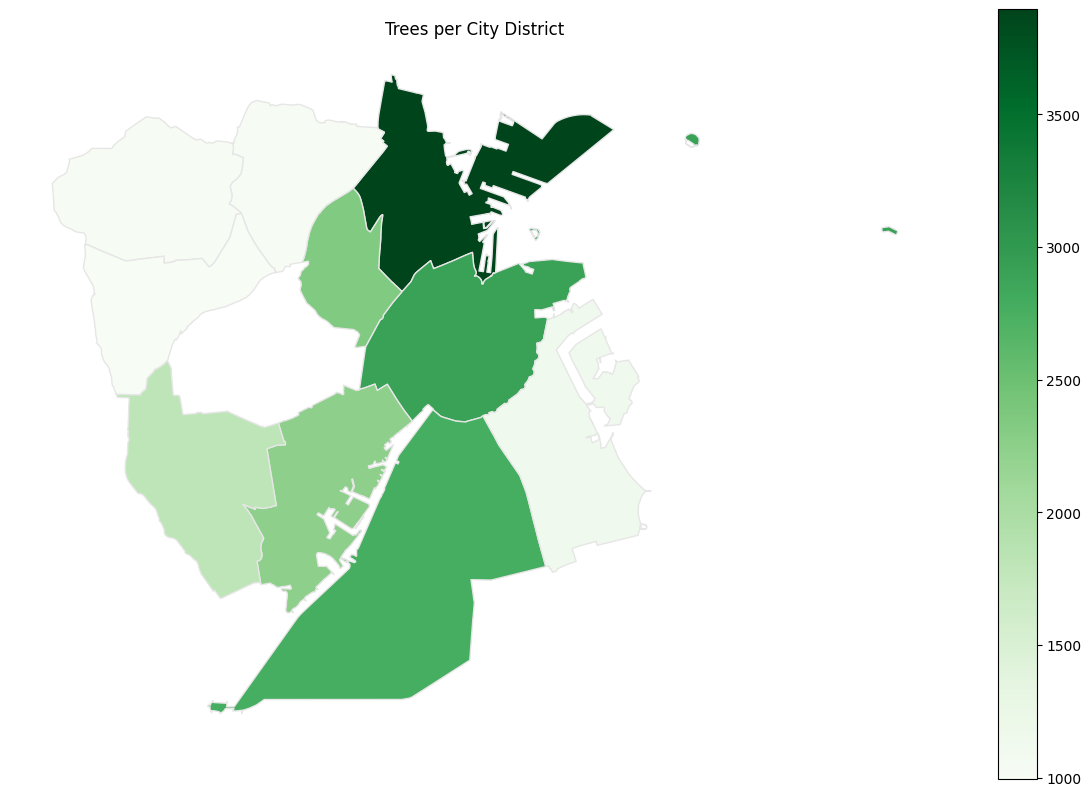

In [457]:
#Tree population heatmap

fig, ax = plt.subplots(1, figsize=(15,10))
trees_districts_gdf.plot(column='count', cmap='Greens', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.set_title("Trees per City District")
ax.axis('off')

(12.438985278000024, 12.748313332195444, 55.606849684208655, 55.73870494954021)

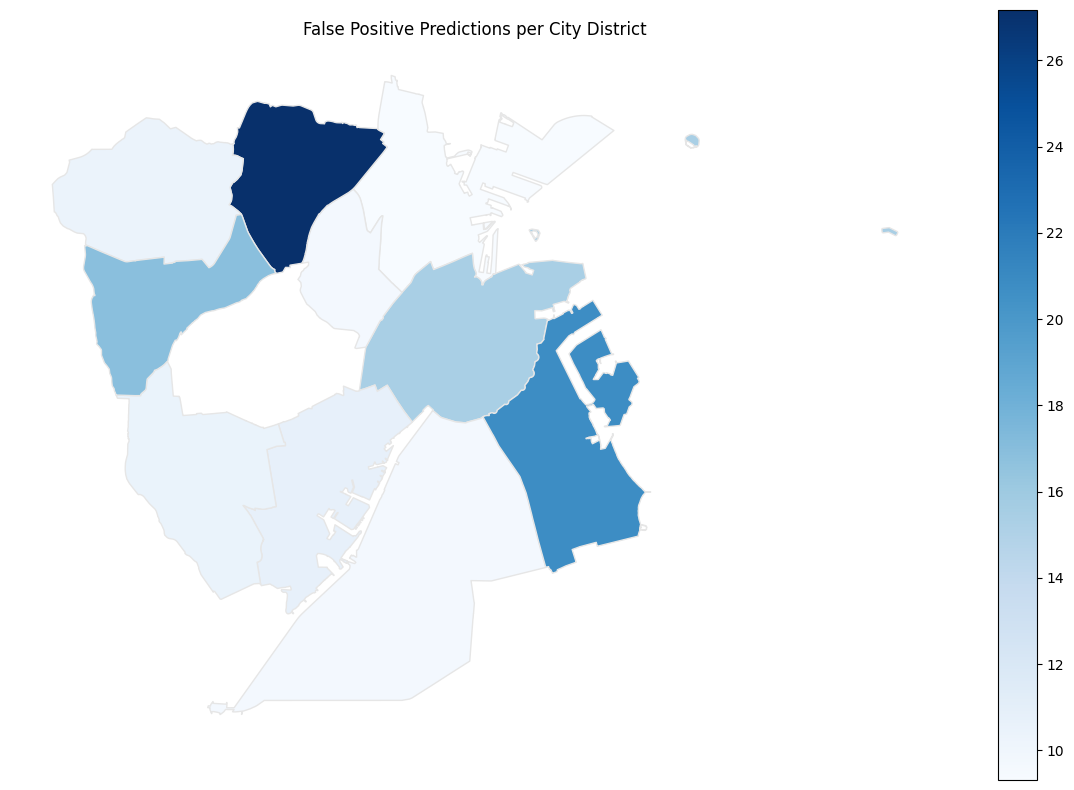

In [458]:
#False positive prediction heatmap

fig, ax = plt.subplots(1, figsize=(15,10))
trees_districts_gdf.plot(column='percentage', cmap='Blues', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.set_title("False Positive Predictions per City District")
ax.axis('off')

In [435]:
#Making heatmap for trees per person

#merged['geometry'] = merged['geometry'].apply(wkt.loads)

merged_gdf = gpd.GeoDataFrame(merged, geometry='geometry')
merged_gdf.head(1)

,count,id,bydel_nr,navn,areal_m2,ogc_fid,geometry,population,trees_per_person
0,3897,1,2.0,Østerbro,9858727.0,5,"POLYGON ((12.59777 55.70348, 12.59700 55.70331...",65877,0.059156


(12.438985278000024, 12.748313332195444, 55.606849684208655, 55.73870494954021)

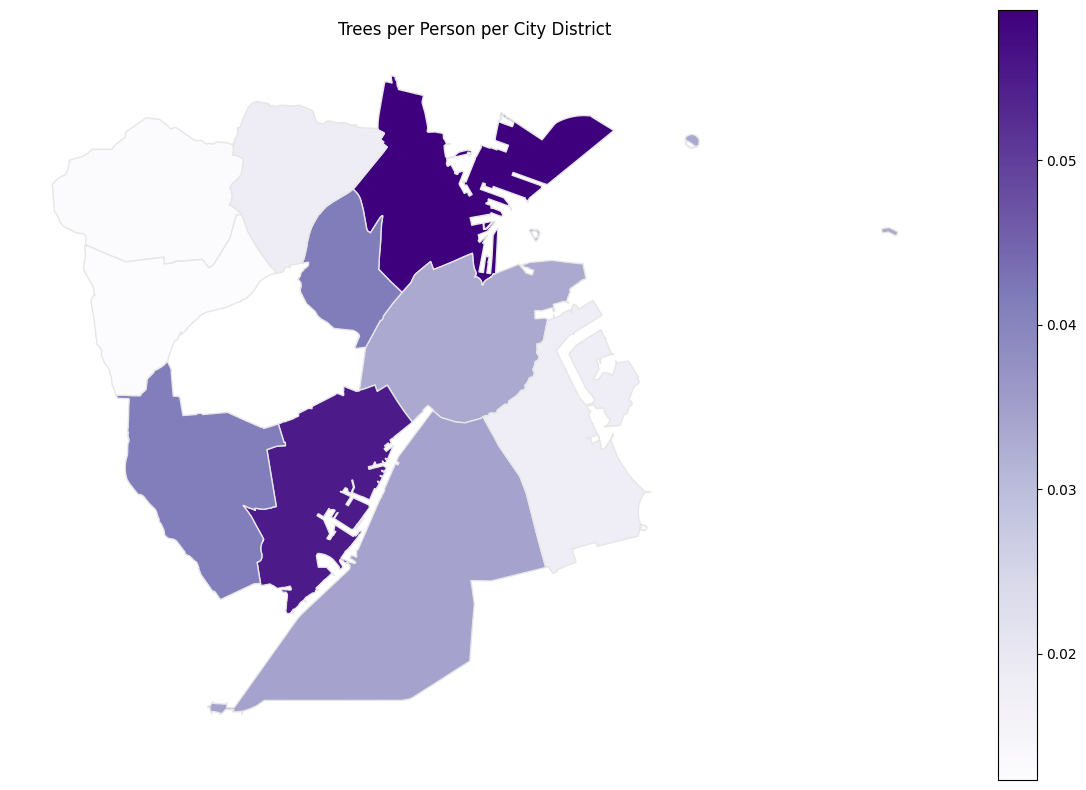

In [459]:
#Trees per person heatmap

fig, ax = plt.subplots(1, figsize=(15,10))
merged_gdf.plot(column='trees_per_person', cmap='Purples', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.set_title("Trees per Person per City District")
ax.axis('off')